In [395]:
'''
Title:       Optimale Steuerung und Regelung:
Subttitle:   2. Aufgabe
Author:      Stefan Kaufmann
MaNr.        51867606
Date:        06.06.2023
'''

'\nTitle:       Optimale Steuerung und Regelung:\nSubttitle:   2. Aufgabe\nAuthor:      Stefan Kaufmann\nMaNr.        51867606\nDate:        06.06.2023\n'

# Optimale Steuerung und Regelung
## 2. Übung - Volldiskretisierung
### Stefan Kaufmann - 51867606

In [396]:
import numpy as np
import matplotlib.pyplot as plt

import casadi as cas
import libop as libop

# 1. Model    
    
$
\dot{X}(t) = f (x(t),u(t)) = 
\begin{bmatrix}
\omega (t) \\
\frac{mga sin{\Theta (t) -d \omega(t) +mau(t) cos{\Theta (t)}}}{J+ma^{2}} \\
v(t) \\
u(t)
\end{bmatrix}
$

In [397]:
global nx, nu, nxu, N, t, Ta, S, M, Q, R


t_end = 2.5
N = 50
t = np.linspace(0,t_end,N+1)

# Anzahl an Zuständen und Eingängen
nx = 4
nu = 1
nxu = nx+nu

M = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1]])

Q = np.eye(4)
S = np.diag([0,0,5,0])
R = np.array([[0.1]])


In [398]:
# Parameter
global J,a,m,d,g

J = 0.0361  # kgm²
a = 0.42    # m
m = 0.3553  # kg
d = 0.005   # Nms
g = 9.81    # m/s²

In [399]:
# System dynamic
def System_dynamic(x,u):

    phidot= x[1]
    phiddot = (m*g*a*np.sin(x[0])+m*a*np.cos(x[0])*u-d*x[1])/(J+m*a**2) 
    v = x[3]
    vdt = u
    
    return cas.vertcat(phidot, phiddot, v, vdt)


# 2. Kostenfunktion   
$
\underset{\mathbf{u(\cdot)},x_{0}} {min}     \qquad   J(u,x_{0}) = \varphi(x(t_{f})) + \int_{t_{0}}^{t{f}} l(x(t),u(t),t) dt   \\
u.B.v. \quad  \dot{x} = f(x,u,t), \quad  x(t_{0}) = x_{0} \quad \Psi (x(t_{f})) = 0 \\
\qquad \qquad  g(x(t),u(t)) = 0 \\ 
\qquad \qquad  h(x(t),u(t)) \leq 0  \qquad  u(t) \in [u_{mini}, u_{max}]
$

In [400]:
# Cost function
def cost(x,u,t):
    # x = [x0 x1 x2 x3 ..], und u = [u0,u1,u2,u3,...]    
    
    cost_ = x[:,N-1].T@S@x[:,N-1]/2            # Endkostenterm 0.5*xSx
    for k in range(0,N-1):        
        dt = t[k+1]-t[k]   
        cost_ += dt*(1+x[:,k].T@Q@x[:,k])/2    #  laufende Kosten  1 + 0.5*(xQx + uRu)       
        cost_ += dt*u[:,k].T@R@u[:,k]/2
    
    return cost_

# 3. Optimierung

In [401]:
global x0, xN

opti = cas.casadi.Opti()

# Minimiere x und u
X = opti.variable(nx,N+1) # State vector [Theta, Omega, s, v]
U = opti.variable(nu,N+1) # Control vector




# Dynamic Constraints
# with Forwardiff
for k in range(N):
    #xnew=  x[:,k] + System_dynamic(x[:,k],u[:,k])*dt                                        # Vorwärtsdifferetation
    dt = t[k+1]-t[k]
    xnew = X[:,k] + (System_dynamic(X[:,k],U[:,k])+System_dynamic(X[:,k+1],U[:,k+1]))*dt/2     # Trapezregel
    #xnew =  libop.runge_kutta_k4(System_dynamic,X[:,k],U[:,k],dt)                          # Runge Kutta rk4
    opti.subject_to(X[:,k+1] == xnew)

# Boundary Conditions
x0 = [np.pi,1e-12,-0.5,0]
xN = [0,0,0,0]

opti.subject_to(X[:,0] == x0)

opti.subject_to(X[0,N] == xN[0])
opti.subject_to(X[1,N] == xN[1])
opti.subject_to(X[3,N-1:] == xN[3])

# Path constraints
opti.subject_to(X[2,:] <= 0.8)
opti.subject_to(X[2,:] >= -0.8)

opti.subject_to(U <=  12)
opti.subject_to(U >= -12)

# Cost-function
 
opti.minimize(cost(X,U,t))


# Solve
opti.set_initial(X[:,0], x0 )
opti.set_initial(X[:,N], xN )

X1_load = np.load('X1.npy')
U1_load = np.load('U1.npy')
if(len(U1_load) == N+1):
    opti.set_initial(X,X1_load)
    #opti.set_initial(U,U1)

# Solver
p_opts = {"expand":True}
s_opts = {"max_iter": 10000}
opti.solver('ipopt', p_opts, s_opts)
sol = opti.solve()

X1 = sol.value(X)
U1 = sol.value(U)

# Abspeichern der Ergebnisse 
np.save('X1.npy',X1)
np.save('U1.npy',U1)


This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      908
Number of nonzeros in inequality constraint Jacobian.:      204
Number of nonzeros in Lagrangian Hessian.............:      299

Total number of variables............................:      255
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      208
Total number of inequality constraints...............:      204
        inequality constraints with only lower bounds:      102
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      102

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.8839089e+01 9.02e-01 4.01e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00  

In [402]:
opti.debug


Opti(Opti {
  instance #82
  #variables: 2 (nx = 255)
  #parameters: 0 (np = 0)
  #constraints: 58 (ng = 412)
  CasADi solver allocated.
  CasADi solver was called: Solve_Succeeded
})

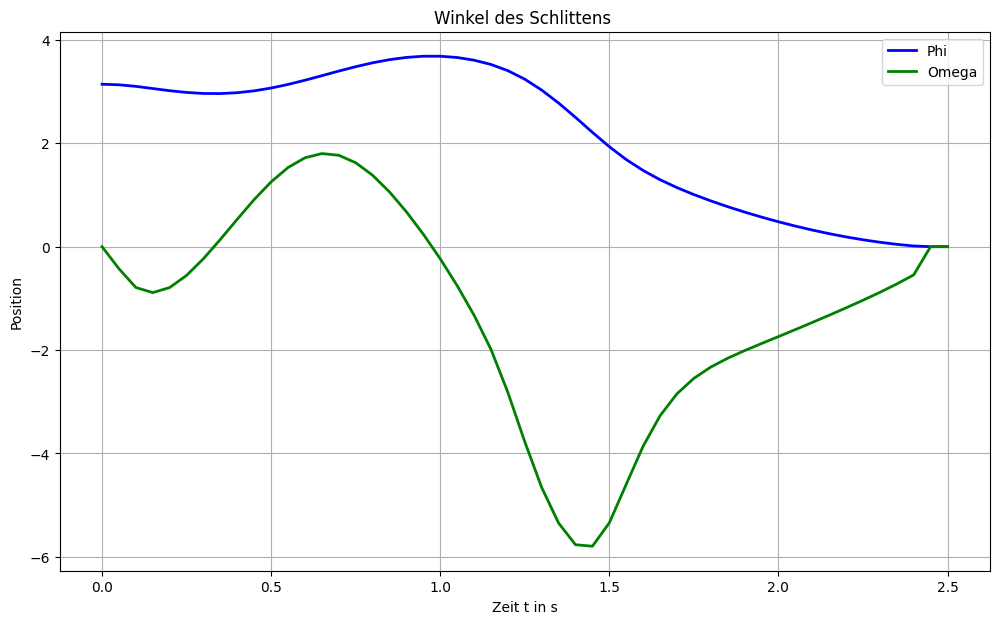

In [403]:
plt.figure(figsize=(12,7))
plt.xlabel('Zeit t in s')
plt.ylabel('Position')
plt.grid()
plt.plot(t,X1[0],'b', linewidth ='2', label = 'Phi')
plt.plot(t,X1[1],'g', linewidth ='2', label = 'Omega')

plt.title('Winkel des Schlittens ')   
plt.legend(loc = 'best')
plt.show()

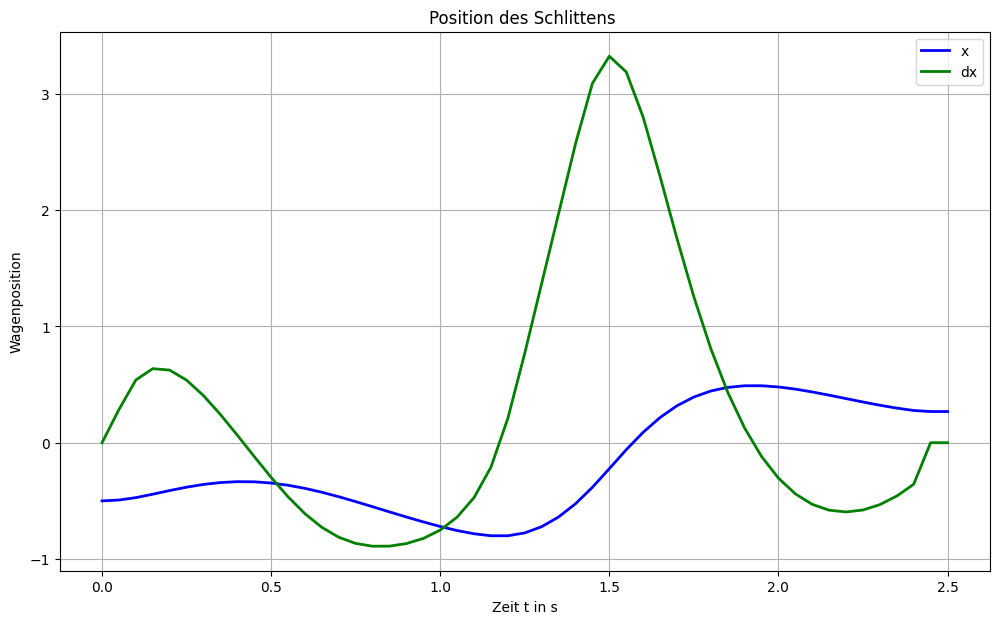

In [404]:
plt.figure(figsize=(12,7))
plt.xlabel('Zeit t in s')
plt.ylabel('Wagenposition')
plt.grid()
plt.plot(t,X1[2],'b', linewidth ='2', label = 'x')
plt.plot(t,X1[3],'g', linewidth ='2', label = 'dx')

plt.title('Position des Schlittens ')   
plt.legend(loc = 'best')
plt.show()

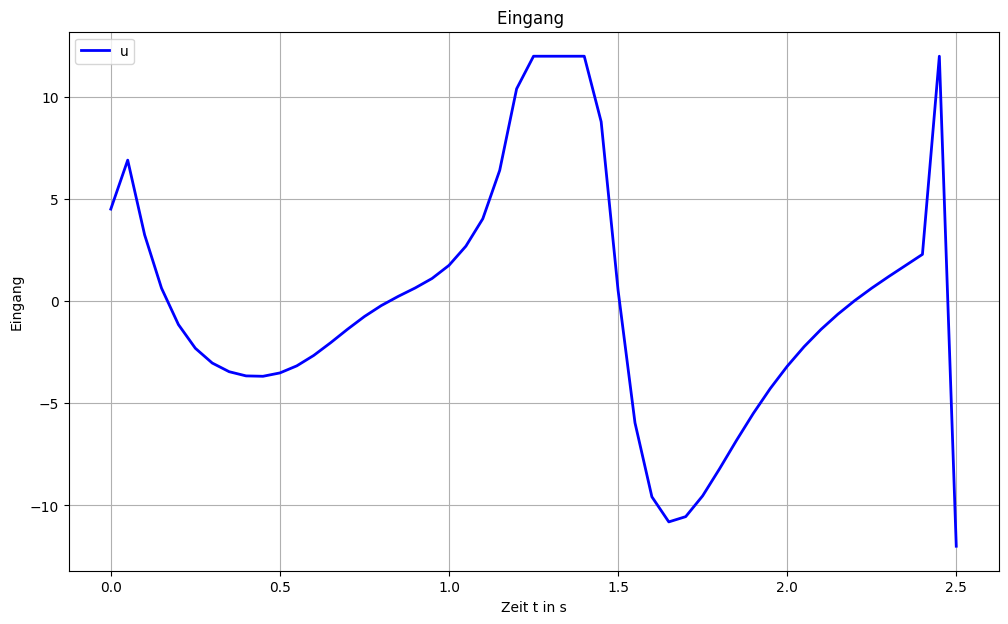

In [405]:
plt.figure(figsize=(12,7))
plt.xlabel('Zeit t in s')
plt.ylabel('Eingang')
plt.grid()
plt.plot(t,U1,'b', linewidth ='2', label = 'u')


plt.title('Eingang ')   
plt.legend(loc = 'best')
plt.show()

# Überprüfung

In [406]:
import control as ct
import control.optimal as obc


def system_update(t, x, u,params):
    # Return the derivative of the state
    return System_dynamic(x,u)

def system_output(t, x, u,params):
    return x

# Define the vehicle steering dynamics as an input/output system
Pendel = ct.NonlinearIOSystem(
    system_update, system_output, states=4, name='Pendel',
    inputs=('u'), outputs=('phi','omega','x','dx'))


input = U1 ;  timepts = t


resp = ct.input_output_response(
    Pendel, timepts, input, x0,
    t_eval=t)
t_sim, y_sim, u_sim = resp.time, resp.outputs, resp.inputs


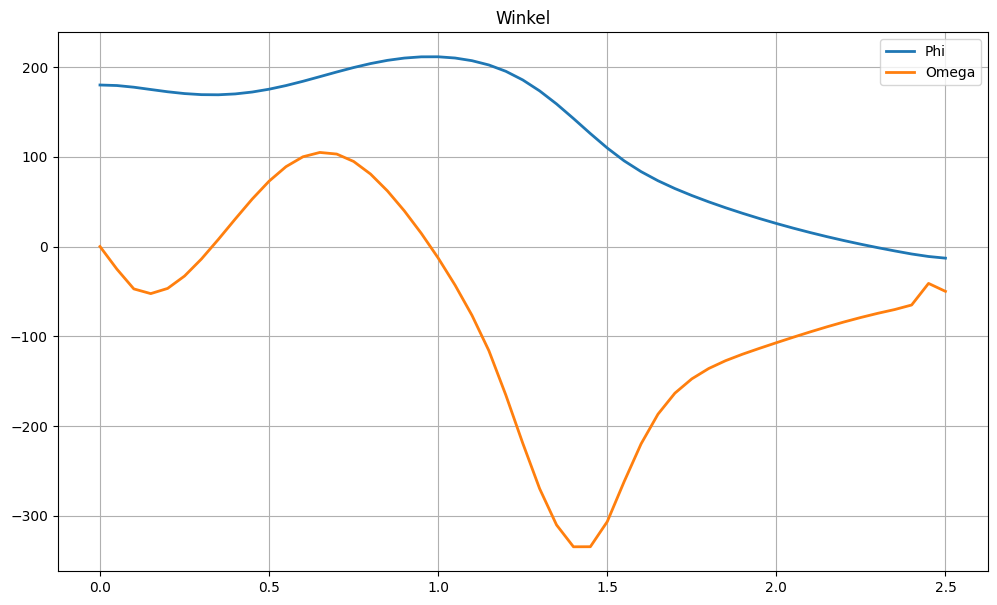

In [407]:
plt.figure(figsize=(12,7))
plt.figure(1)
#plt.plot(t_sim, y_sim[0])
plt.plot(t_sim, y_sim[0]*180/np.pi, linewidth ='2', label = 'Phi')
plt.plot(t_sim, y_sim[1]*180/np.pi, linewidth ='2', label = 'Omega')
#plt.plot(t_sim, y_sim[2])
plt.grid()
plt.title('Winkel')
plt.legend(loc = 'best')

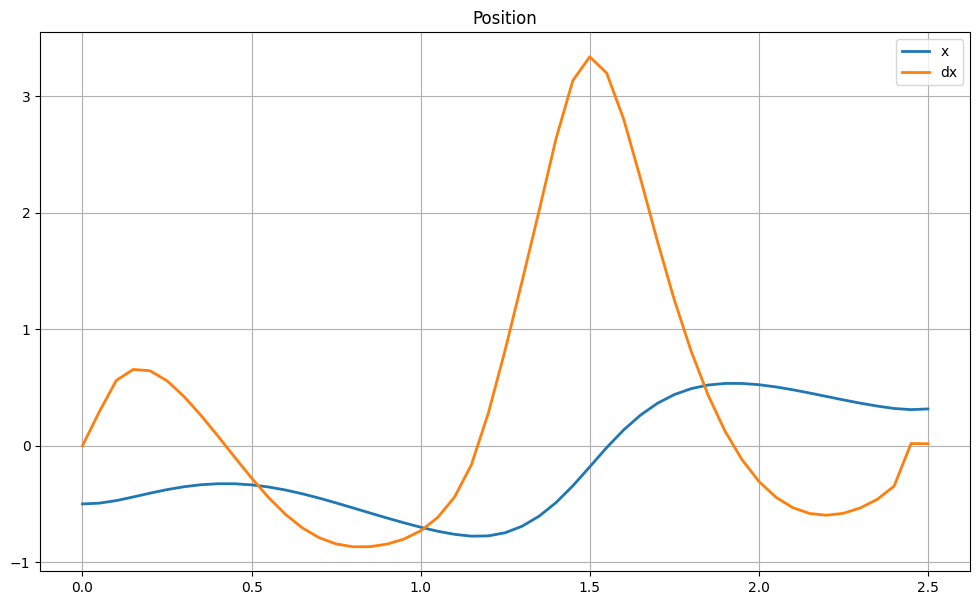

In [408]:
plt.figure(figsize=(12,7))
plt.figure(1)
plt.plot(t_sim, y_sim[2], linewidth ='2', label = 'x')
plt.plot(t_sim, y_sim[3], linewidth ='2', label = 'dx')
#plt.plot(t_sim, y_sim[2])
plt.grid()
plt.title('Position')
plt.legend(loc = 'best')

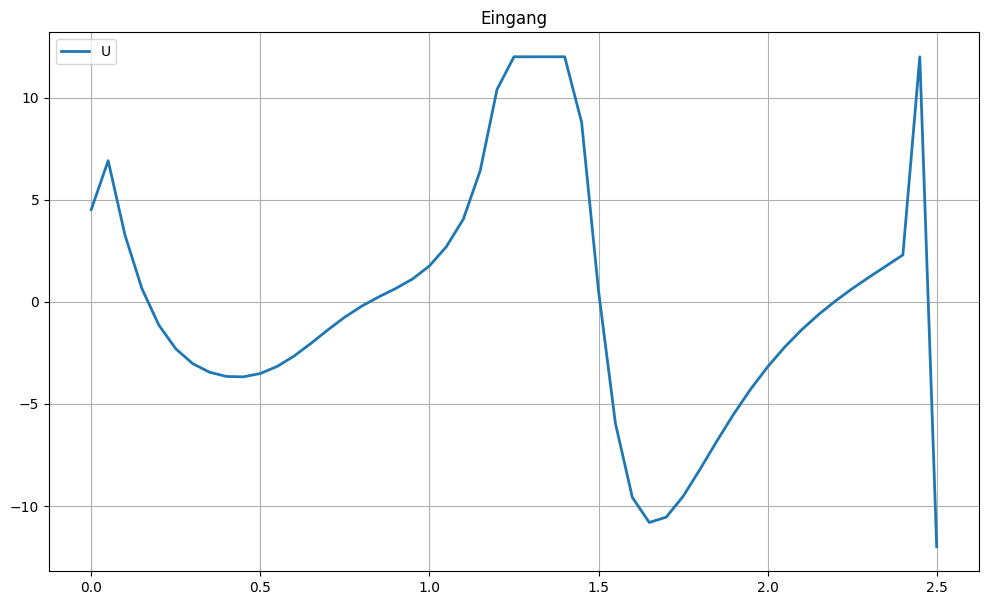

In [409]:
plt.figure(figsize=(12,7))
plt.figure(1)
plt.plot(t_sim, u_sim[0], linewidth ='2', label = 'U')
#plt.plot(t_sim, y_sim[2])
plt.grid()
plt.title('Eingang')
plt.legend(loc = 'best')